In [219]:
import h5py
import os

directory = "./data/"
data_folder = directory
output_folder =  './'

h5_files = os.listdir(data_folder)
sorted_files = sorted(h5_files, key=lambda x: int(x.split(' ')[9]))

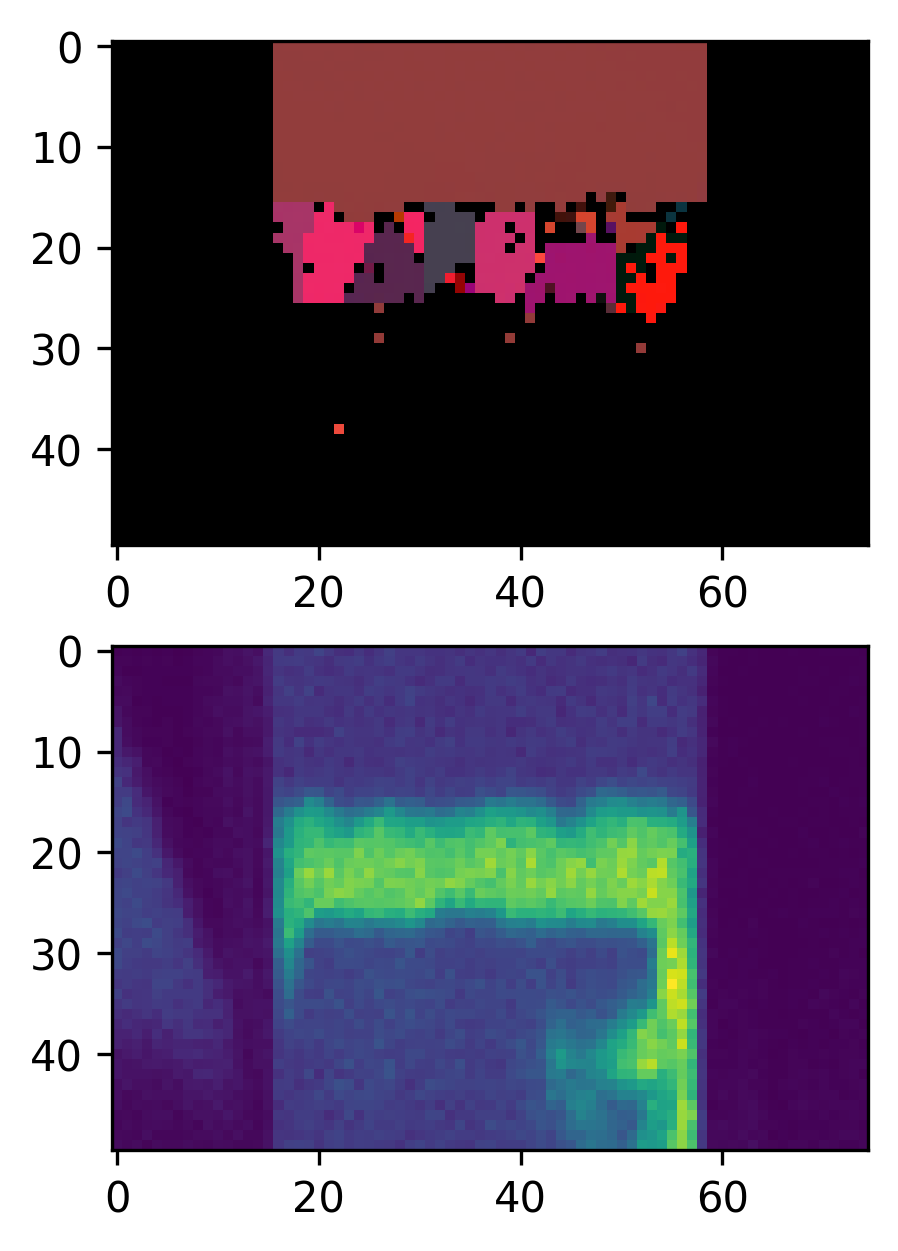

In [220]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
import matplotlib.colors as colors

fig, axs = plt.subplots(2,1,dpi=300)
f = h5py.File(data_folder+sorted_files[-10], 'r')


image_resolution = (f['1/EDS/Header/X Cells'][0],f['1/EDS/Header/Y Cells'][0])
crop = slice(0, 50),slice(30, 105)

data = np.array(f['1/EBSD/Data/Euler']).reshape(image_resolution[1],image_resolution[0],3)[crop]

data[:,:,0] = data[:,:,0]/(2*np.pi)
data[:,:,1] = data[:,:,1]/(np.pi)
data[:,:,2] = data[:,:,2]/(np.pi)

ref_data = data


map1 = axs[0].imshow(data)
#c = fig.colorbar(map1, ax=axs)

#axs[0].set_xlim(0,f['1/EBSD/Header/Bounding Box Size'][0])
#axs[0].set_ylim(0,f['1/EBSD/Header/Bounding Box Size'][1])



data = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])[crop]



map2 = axs[1].imshow(data)


In [221]:
np.array(f['1/EBSD/Data/Euler'])[:,0].min()

0.0

In [222]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift


shifts = np.zeros((len(sorted_files),2),dtype='int32')
shifts[25:] += np.array((17,0))
shifts[28] += np.array((-8,0))

def update(frame):
    file = sorted_files[frame]

    f = h5py.File(data_folder+file, 'r')

    

    data = np.array(f['1/EBSD/Data/Euler']).reshape(image_resolution[1],image_resolution[0],3)[crop]

    data[:,:,0] = data[:,:,0]/(2*np.pi)
    data[:,:,1] = data[:,:,1]/(np.pi)
    data[:,:,2] = data[:,:,2]/(np.pi)

    shift = shifts[frame]

    offset_data = np.roll(data,shift,axis=(0,1))

    map1.set_array(offset_data)

    map1.set_extent((0,f['1/EBSD/Header/Bounding Box Size'][0],0,f['1/EBSD/Header/Bounding Box Size'][1]))

    axs[0].set_xlim(0,f['1/EBSD/Header/Bounding Box Size'][0])
    axs[0].set_ylim(0,f['1/EBSD/Header/Bounding Box Size'][1])

    data = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])[crop]

    offset_data = np.roll(data,shift,axis=(0,1))

    map2.set_array(offset_data)

    map2.set_extent((0,f['1/EBSD/Header/Bounding Box Size'][0],0,f['1/EBSD/Header/Bounding Box Size'][1]))

    return (map1,map2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=len(sorted_files), interval=30)

ani.save('test.mp4', writer = 'ffmpeg', fps = 2) 